In [2]:
######################################################################
# Semi-Supervised Classification of Graph Nodes using Exponential Decay
# L42: Assessment 2
# Jan Ondras (jo356), Trinity College
######################################################################
# Baseline MLP testing + show results from validation, Cora dataset
#############################################################################################################
# Load data 
#############################################################################################################

import keras
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import time
import os
from gcn.utils import *

dataset_type = 'cora'

# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(dataset_type)

if dataset_type == 'cora':
    N_classes = 7
    N_features = 1433
    N_nodes = 2708
    N_edges = 5278 #5429 - incorrect in paper !
    if N_classes != y_train.shape[1] or N_features != features.shape[1] or N_nodes != features.shape[0] or N_edges != np.sum(adj.todense())/2:
        raise ValueError("Dataset dimensions differ from expected!")
else:
    raise ValueError("Dataset not supported!")
print dataset_type, "dataset:", "#classes =", N_classes, ", #features =", N_features, ", #nodes =", N_nodes, ", #edges =", N_edges

X_train = features[train_mask].toarray()
X_val = features[val_mask].toarray()
X_test = features[test_mask].toarray()
y_train = y_train[train_mask]
y_val = y_val[val_mask]
y_test = y_test[test_mask]

print "Feature set shapes (train, valid, test):", X_train.shape, X_val.shape, X_test.shape
print "Labels shapes (train, valid, test):", y_train.shape, y_val.shape, y_test.shape

Using TensorFlow backend.


cora dataset: #classes = 7 , #features = 1433 , #nodes = 2708 , #edges = 5278
Feature set shapes (train, valid, test): (140, 1433) (500, 1433) (1000, 1433)
Labels shapes (train, valid, test): (140, 7) (500, 7) (1000, 7)


In [3]:
#############################################################################################################
# Load validation data 
#############################################################################################################

ID = 0 # zeroth trial,  smaller # of hidden sizes
ID = 1 # first ok trial, higher # of hidden sizes

data = np.load('./../../../Dataset/baseline_' + str(ID) + '.npz')
vals = data['vals']
vals_std = data['vals_std']
N_hl_range = data['N_hl_range']
N_hu_range = data['N_hu_range']
N_runs = data['N_runs']
dropout = data['dropout']
epochs = data['epochs']

train_batch_size = len(X_train)
val_batch_size = len(X_val)
test_batch_size = len(X_test)

best_N_hl = N_hl_range[np.argmax(vals) // len(N_hu_range)]
best_N_hu = N_hu_range[np.argmax(vals) % len(N_hu_range)]

print "# hidden layers range", N_hl_range
print "# hidden units range", N_hu_range
print "Optimal number of hidden layers: ", best_N_hl
print "Optimal number of hidden units: ",  best_N_hu
print "Best validation accuracy: ", np.max(vals), vals[np.argmax(vals) // len(N_hu_range), np.argmax(vals) % len(N_hu_range)], vals.shape, np.argmax(vals)
print "dropout", dropout, "\tN_runs", N_runs

# hidden layers range [ 1  2  3  4  5  6  7  8  9 10]
# hidden units range [10 15 20 25 30 35 40 45 50 55 60 65 70 75 80]
Optimal number of hidden layers:  2
Optimal number of hidden units:  60
Best validation accuracy:  0.572300001383 0.572300001383 (10, 15) 25
dropout 0.5 	N_runs 100


0.0842999996617


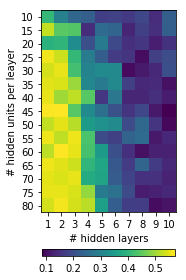

Baseline method: validation accuracy in terms of hidden layer size (x) and number of hidden units per layer (y)


In [35]:
vmin= np.min(vals)
vmax = np.max(vals)
# mid_val = 0.15
# cmap = 'hot_r' #'coolwarm'
print vmin
# vmax = 0.695440005958
# vmin = 0.0842999996617

plt.figure()
# plt.imshow(vals, cmap=cmap, clim=(vmin, vmax), 
#            norm=MidpointNormalize(midpoint=mid_val,vmin=vmin, vmax=vmax))
plt.imshow(vals.T) # , vmax = 0.6 , cmap=cmap
plt.xticks(range(len(N_hl_range)), N_hl_range)
plt.yticks(range(len(N_hu_range)), N_hu_range)
plt.xlabel('# hidden layers')
plt.ylabel('# hidden units per leayer')
plt.colorbar(orientation="horizontal", fraction=0.027)
plt.tight_layout()
plt.show()
print "Baseline method: validation accuracy in terms of hidden layer size (x) and number of hidden units per layer (y)"

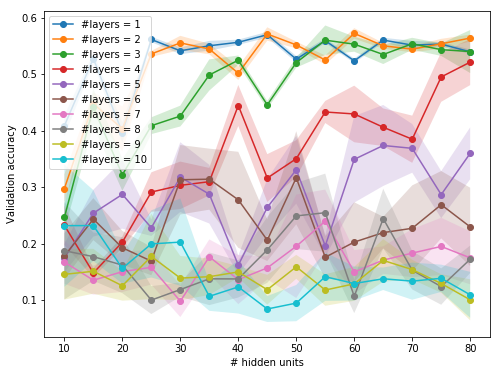

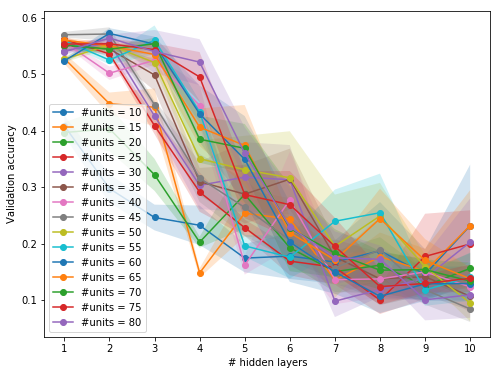

Showing  1.0  stds


In [7]:
#############################################################################################################
# PLOT results from validation
#############################################################################################################
N_std = 1. # stds to show

plt.figure(figsize=[8,6])
for a, N_hl in enumerate(N_hl_range):
    plt.plot(N_hu_range, vals[a],'o-', label='#layers = '+str(N_hl))
    plt.fill_between(N_hu_range, vals[a]-N_std*vals_std[a], vals[a]+N_std*vals_std[a], alpha=.2)
plt.legend()
plt.xlabel('# hidden units')
plt.ylabel('Validation accuracy')
# plt.title('Loss Curves',fontsize=16)
plt.show()

# PLOT ALL !!!
plt.figure(figsize=[8,6])
for b, N_hu in enumerate(N_hu_range):
    plt.plot(N_hl_range, vals[:,b],'o-', label='#units = '+str(N_hu))
    plt.fill_between(N_hl_range,  vals[:,b]-N_std*vals_std[:,b],  vals[:,b]+N_std*vals_std[:,b], alpha=.2)
plt.legend()
plt.xlabel('# hidden layers')
plt.ylabel('Validation accuracy')
plt.xticks(N_hl_range, N_hl_range)
# plt.title('Loss Curves',fontsize=16)
plt.show()
print "Showing ",N_std, " stds"

In [6]:
#############################################################################################################
# Train and Test the best model, again averaged over 100 runs with rand init
#############################################################################################################

# best_N_hl   # from above
# best_N_hu

# Create model
model = Sequential()
model.add(Dense(best_N_hu, activation='relu', kernel_initializer='he_uniform', input_dim=N_features))
model.add(Dropout(dropout))
for i in range(1, best_N_hl):
    model.add(Dense(best_N_hu, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(dropout))
model.add(Dense(N_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print model.summary()
early_stop = EarlyStopping(monitor='val_acc', patience=10, verbose=0) # stop after 10 epochs without improvement in val_acc

test_acc = []
for i in range(N_runs):
    model.fit(X_train, y_train, epochs=epochs, batch_size=train_batch_size, 
               validation_data = (X_val, y_val), verbose=0, callbacks=[early_stop])

    test_acc.append( model.evaluate(X_test, y_test, batch_size=test_batch_size, verbose=0)[1] )

print "Test set accuracy: ", np.mean(test_acc), "+/-", np.std(test_acc)
print "Baseline accuracy (chance level): ", 1./N_classes

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 60)                86040     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 60)                3660      
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 427       
Total params: 90,127
Trainable params: 90,127
Non-trainable params: 0
_________________________________________________________________
None
Test set accuracy:  0.554350004196 +/- 0.00574173480228
Baseline accuracy (chance level):  0.142857142857


In [ ]:
Test set accuracy:  0.554350004196 +/- 0.00574173480228
Baseline accuracy (chance level):  0.142857142857